##### Jupyter Notebook, Step 1 - Benchmarking
- build pipeline to perform a naive fit for each of the base model classes:
	- logistic regression
	- decision tree
	- k nearest neighbors
	- support vector classifier
- in order to do this, you will need to set a high `C` value in order to perform 
minimal regularization, in the case of logistic regression and support vector classifier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve,confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import (precision_score, 
                             accuracy_score, 
                             roc_auc_score, 
                             roc_curve, 
                             precision_recall_curve, 
                             recall_score,
                             make_scorer,
                             auc)
                            
from tqdm import tqdm

%matplotlib inline

In [2]:
class Read_UCI_madelon_Data(object):
   
    # Initializing object.
    def __init__(self):
       
        self.data_dir = '../data/MadelonUCIData/'

        self.XtestData_file   = self.data_dir + 'madelon_test_data.csv'
        self.XtrainData_file  = self.data_dir + 'madelon_train_data.csv'
        self.XvalidData_file  = self.data_dir + 'madelon_valid_data.csv'  
        self.yvalid_file      = self.data_dir + 'madelon_valid_labels.csv'
        self.ytrain_file      = self.data_dir + 'madelon_train_labels.csv'

        self.read_all_data_from_files()
    
        
    def get_X_train_data(self):
        return(self.X_train_data_df)
    
    def get_X_valid_data(self):
        return(self.X_valid_data_df)   

    def get_X_test_data(self):
        return(self.X_test_data_df)
       
    def get_y_train_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column
        # with each element as a list of one int.  We want it to be just an int not a list.
        self.y_train_arr = np.array([val[0] for val in self.y_train_df.values])
        return(self.y_train_arr)
    
    def get_y_valid_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column
        # with each element as a list of one int.  We want it to be just an int not a list.
        self.y_valid_arr = np.array([val[0] for val in self.y_valid_df.values])
        return(self.y_valid_arr)
   
    def read_all_data_from_files(self):
            self.X_test_data_df    = pd.read_csv(self.XtestData_file, delimiter=' ', header=None)
            self.X_train_data_df   = pd.read_csv(self.XtrainData_file, delimiter=' ', header=None)
            self.X_valid_data_df   = pd.read_csv(self.XvalidData_file, delimiter=' ', header=None)
            self.y_valid_df        = pd.read_csv(self.yvalid_file, delimiter=' ', header=None)
            self.y_train_df        = pd.read_csv(self.ytrain_file, delimiter=' ', header=None)

In [3]:
# Read in the Madelon UCI data.
UCI_madelonData = Read_UCI_madelon_Data()

# Get the X train data, X test data and X validate data.
X_train_data_df = UCI_madelonData.get_X_train_data()
X_valid_data_df = UCI_madelonData.get_X_valid_data()
X_test_data_df =  UCI_madelonData.get_X_test_data()

In [4]:
# Check for nulls.
X_train_col_null_cnt = X_train_data_df.isnull().sum()
X_valid_col_null_cnt = X_valid_data_df.isnull().sum()
X_test_col_null_cnt = X_test_data_df.isnull().sum()

# Since col 500 seems to be all nulls, let's drop it from all the X dataframes.
X_train_data_df.drop(500, axis = 1, inplace=True)
X_valid_data_df.drop(500, axis = 1, inplace=True)
X_test_data_df.drop(500, axis = 1, inplace=True)

print(X_train_data_df.isnull().sum().sum())
print(X_valid_data_df.isnull().sum().sum())
print(X_test_data_df.isnull().sum().sum())

0
0
0


In [5]:
X_train_data_df.shape, X_valid_data_df.shape, X_test_data_df.shape

((2000, 500), (600, 500), (1800, 500))

In [6]:
# Now lets read in the y_train data. It is 2000 rows by 1 col. and there are no nulls.
y_train_data = UCI_madelonData.get_y_train_data()
y_train_data.shape, np.isnan(y_train_data).sum()

((2000,), 0)

In [7]:
# Now lets read in the y_valid data. It is 600 rows by 1 col. and there are no nulls.
y_valid_data = UCI_madelonData.get_y_valid_data()
y_valid_data.shape, np.isnan(y_valid_data).sum()

((600,), 0)

In [8]:
# I will take 600 random samples (rows) from the 2000 rows of data.
# We need 3 sets of 200 (10%) rows of data. I
sampleX_df = X_train_data_df.sample(n=600, axis = 0)

In [9]:
# Let's look at the standard deviation, means and univariate distribution of out data.

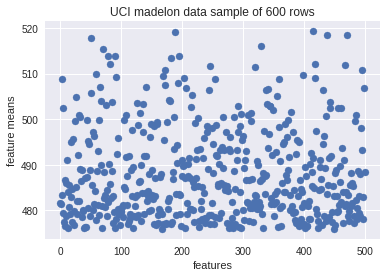

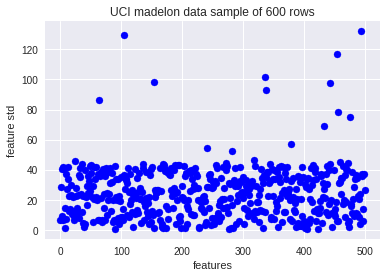

In [20]:
# plot mean and std of features.
plt.scatter(sampleX_df.columns, sampleX_df.mean())
plt.title('UCI madelon data sample of 600 rows')
plt.xlabel('features')
plt.ylabel('feature means')
plt.show()

plt.scatter(sampleX_df.columns, sampleX_df.std(), c='b', cmap='OrRd')
plt.title('UCI madelon data sample of 600 rows')
plt.xlabel('features')
plt.ylabel('feature std')
plt.show()

In [25]:
sampleX_df.iloc[:,0]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
           dtype='int64', length=500)

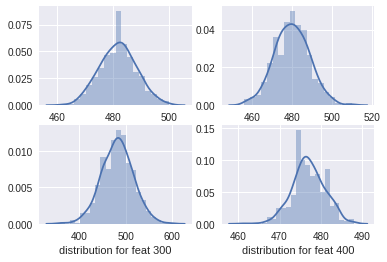

In [37]:
# univariate distribution of features. 
plt.subplot(2,2,1)
sns.distplot(sampleX_df.iloc[:,0], axlabel='distribution for feat 0')
plt.subplot(2,2,2)
sns.distplot(sampleX_df.iloc[:,100], axlabel='distribution for feat 100')
plt.subplot(2,2,3)
sns.distplot(sampleX_df.iloc[:,300], axlabel='distribution for feat 300')
plt.subplot(2,2,4)
sns.distplot(sampleX_df.iloc[:,400], axlabel='distribution for feat 400')

In [14]:
# Split the train data into 3 sets of 10% of data. 
# Since the data is 2000 rows we need 3 samples of 200
# rows each. I will get 600 random samples and split them into 
# 3 groups.

X_train_data_df_1 = sampleX_df.iloc[0:200,:]
X_train_data_df_2 = sampleX_df.iloc[200:400,:]
X_train_data_df_3 = sampleX_df.iloc[400:600,:]


# Get the corresponding y_train values for the 600 sampled
# rows of train_data.

sampley = y_train_data[sampleX_df.index]
y_train_data_1 = sampley[0:200]
y_train_data_2 = sampley[200:400]
y_train_data_3 = sampley[400:600]


In [15]:
# Pickle the DataFrames for all the X train, test, validate and y data.
# So I can use in other notebooks.

X_train_data_df.to_pickle('../data/dataNB1/X_train_data_df.p')
X_train_data_df_1.to_pickle('../data/dataNB1/X_train_data_df_1.p')
X_train_data_df_2.to_pickle('../data/dataNB1/X_train_data_df_2.p')
X_train_data_df_3.to_pickle('../data/dataNB1/X_train_data_df_3.p')

X_valid_data_df.to_pickle('../data/dataNB1/X_valid_data_df.p')
X_test_data_df.to_pickle('../data/dataNB1/X_test_data_df.p')

pd.DataFrame(y_train_data).to_pickle('../data/dataNB1/y_train_data.p')
pd.DataFrame(y_train_data_1).to_pickle('../data/dataNB1/y_train_data_1.p')
pd.DataFrame(y_train_data_2).to_pickle('../data/dataNB1/y_train_data_2.p')
pd.DataFrame(y_train_data_3).to_pickle('../data/dataNB1/y_train_data_3.p')

In [16]:
pd.DataFrame(y_valid_data).to_pickle('../data/dataNB1/y_valid_data_3.p')

** USE THESE PICKLED DATA SET SAMPLES FOR CONSISTENCY **

In [7]:
# I will read in pickled X train and y rain subset data so my results are consistent.
# I can remove before submitting.
X_train_data_df_1 = pd.read_pickle('../data/dataNB1/' +'X_train_data_df_1.p')
X_train_data_df_2 = pd.read_pickle('../data/dataNB1/' +'X_train_data_df_2.p')
X_train_data_df_3 = pd.read_pickle('../data/dataNB1/' +'X_train_data_df_3.p')
        
y_train_data_1 = pd.read_pickle('../data/dataNB1/' + 'y_train_data_1.p')
y_train_data_2 = pd.read_pickle('../data/dataNB1/' + 'y_train_data_2.p')
y_train_data_3 = pd.read_pickle('../data/dataNB1/' + 'y_train_data_3.p')

y_train_data_1 = np.array([val[0] for val in y_train_data_1.values])
y_train_data_2 = np.array([val[0] for val in y_train_data_2.values])
y_train_data_3 = np.array([val[0] for val in y_train_data_3.values])

In [8]:
# Make a list of our X and y train data subsets.
X_train_lst = [X_train_data_df_1,X_train_data_df_2,X_train_data_df_3]
y_train_lst = [y_train_data_1,y_train_data_2,y_train_data_3]

In [9]:
# Log output
def log_output(dataset_name, model_name, raw_output, sc_output):
    entry = {                
                'dataset'           :  dataset_name,
                'model'             :  model_name,
                'raw_tr_acc_score'  :  raw_output['train_score'],
                'raw_tst_acc_score' :  raw_output['test_score'],
                'sc_tr_acc_score'   :  sc_output['train_score'],
                'sc_tst_acc_score'  :  sc_output['test_score'],
                'raw_recall'        :  raw_output['recall'],
                'raw_precision'     :  raw_output['precision'],
                'sc_recall'         :  sc_output['recall'],
                'sc_precision'      :  sc_output['precision']
            }
    return(entry)

In [10]:
def fit_and_score_pipeline(pipe, Xtrain, Xtest, ytrain, ytest, target_names):
    
    # Fit and score Logistic Regression raw pipeline.
    pipe.fit(Xtrain, ytrain) 
    
    # Mean accuracy score is returned.
    train_score = pipe.score(Xtrain,ytrain)
    test_score = pipe.score(Xtest,ytest)  
    y_pred = pipe.predict(Xtest)

    # Calculate precision and recall.   
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
  
    output = {'train_score':train_score, 
              'test_score':test_score, 
              'recall':recall, 
              'precision':precision}
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
  
    return(output, class_report_str, conf_matrix_raw)


In [11]:
# Save mean accuracy scores, classification reports and confusion matrix.
model_results = []
confusion_mtx = {}
classification_rep = {}
target_names=['class -1', 'class 1']

In [12]:
#************************ Benchmark *************************** 
# Use high C=1e10 for logistic regression and support
# vector classifier, so there is no regularization. 
# KNeighbors default is k=5
#**************************************************************

In [13]:
# Fit naive models to benchmark the 3 data subsets.
for tst_set in tqdm(range(3)):

    # Split the data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train_lst[tst_set], 
                                                    y_train_lst[tst_set], 
                                                    test_size=0.33)
                              
    # Logistic Regression pipes.
    LR_naive_raw_pipe  =   make_pipeline(LogisticRegression(C=1e10, random_state=42))
    LR_naive_scaled_pipe = make_pipeline(StandardScaler(), 
                                         LogisticRegression(C=1e10, random_state=42))
    
    # fit and score pipeline with raw and scaled data. Results are stored in a dict.
    raw_output, cl_report_str, conf_mtx = fit_and_score_pipeline(LR_naive_raw_pipe, 
                                                                 Xtrain, Xtest,     
                                                                 ytrain, ytest,
                                                                 target_names=target_names)

    # Save classification report and confusion matrix, raw data.
    classification_rep['LR_raw_report'] = cl_report_str
    confusion_mtx['LR_raw_conf_mtx'] = conf_mtx
                                           
    sc_output, cl_report_str, conf_mtx = fit_and_score_pipeline(LR_naive_scaled_pipe, 
                                                                Xtrain, Xtest, 
                                                                ytrain, ytest,
                                                                target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    classification_rep['LR_scaled_report'] = cl_report_str
    confusion_mtx['LR_scaled_conf_mtx'] = conf_mtx
    
    # Output results
    entry    = log_output(dataset_name = 'Set_'+str(tst_set+1), 
                          model_name   = 'LogisticRegression', 
                          raw_output   = raw_output,
                          sc_output    = sc_output)

    model_results.append(entry)
    
    #*******************************************************************************
    
    # SVC pipes.
    SVC_naive_raw_pipe =  make_pipeline(SVC(C=1e10, random_state=42))                                  
    SVC_naive_scaled_pipe = make_pipeline(StandardScaler(), 
                                          SVC(C=1e10, random_state=42))                                  

        
    # fit and score pipeline with raw and scaled data. Results are stored in a dict.
    raw_output, cl_report_str, conf_mtx = fit_and_score_pipeline(SVC_naive_raw_pipe, 
                                                                 Xtrain, Xtest,     
                                                                 ytrain, ytest,
                                                                 target_names=target_names)

    # Save classification report and confusion matrix, raw data.
    classification_rep['SVC_raw_report'] = cl_report_str
    confusion_mtx['SVC_raw_conf_mtx'] = conf_mtx
                                           
    sc_output, cl_report_str, conf_mtx = fit_and_score_pipeline(SVC_naive_scaled_pipe, 
                                                                Xtrain, Xtest, 
                                                                ytrain, ytest,
                                                                target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    classification_rep['SVC_scaled_report'] = cl_report_str
    confusion_mtx['SVC_scaled_conf_mtx'] = conf_mtx       
    
    # Output results
    entry = log_output(dataset_name = 'Set_'+str(tst_set+1), 
                       model_name   = 'SVC', 
                       raw_output   = raw_output,
                       sc_output    = sc_output)

    model_results.append(entry)    

    #*******************************************************************************

    # Decision Tree pipes.
    DT_naive_raw_pipe  =  make_pipeline(DecisionTreeClassifier(random_state=42))
    DT_naive_scaled_pipe = make_pipeline(StandardScaler(), 
                                         DecisionTreeClassifier(random_state=42))

    # fit and score pipeline with raw and scaled data. Results are stored in a dict.
    raw_output, cl_report_str, conf_mtx = fit_and_score_pipeline(DT_naive_raw_pipe, 
                                                                 Xtrain, Xtest,     
                                                                 ytrain, ytest,
                                                                 target_names=target_names)

    # Save classification report and confusion matrix, raw data.
    classification_rep['DT_raw_report'] = cl_report_str
    confusion_mtx['DT_raw_conf_mtx'] = conf_mtx
                                           
    sc_output, cl_report_str, conf_mtx = fit_and_score_pipeline(DT_naive_scaled_pipe, 
                                                                Xtrain, Xtest, 
                                                                ytrain, ytest,
                                                                target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    classification_rep['DT_scaled_report'] = cl_report_str
    confusion_mtx['DT_scaled_conf_mtx'] = conf_mtx   
    
    # Output results
    entry = log_output(dataset_name = 'Set_'+str(tst_set+1), 
                       model_name   = 'DecisionTree', 
                       raw_output   = raw_output,
                       sc_output    = sc_output)

    model_results.append(entry)
  
    #*******************************************************************************
   
    # KNN pipes.
    KNN_naive_raw_pipe =  make_pipeline(KNeighborsClassifier())
    KNN_naive_scaled_pipe = make_pipeline(StandardScaler(), 
                                          KNeighborsClassifier())                                   

    # fit and score pipeline with raw and scaled data. Results are stored in a dict.
    raw_output, cl_report_str, conf_mtx = fit_and_score_pipeline(KNN_naive_raw_pipe, 
                                                                 Xtrain, Xtest,     
                                                                 ytrain, ytest,
                                                                 target_names=target_names)

    # Save classification report and confusion matrix, raw data.
    classification_rep['KNN_raw_report'] = cl_report_str
    confusion_mtx['KNN_raw_conf_mtx'] = conf_mtx
                                           
    sc_output, cl_report_str, conf_mtx = fit_and_score_pipeline(KNN_naive_scaled_pipe, 
                                                                Xtrain, Xtest, 
                                                                ytrain, ytest,
                                                                target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    classification_rep['KNN_scaled_report'] = cl_report_str
    confusion_mtx['KNN_scaled_conf_mtx'] = conf_mtx   
    
    # Output results.
    entry = log_output(dataset_name = 'Set_'+str(tst_set+1), 
                       model_name   = 'KNN', 
                       raw_output   = raw_output,
                       sc_output    = sc_output)
    
    model_results.append(entry)
        

  0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 33%|███▎      | 1/3 [00:00<00:00,  3.97it/s]/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

In [14]:
# Put all results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am here specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'raw_tr_acc_score', \
                                     'raw_tst_acc_score', 'raw_precision', 'raw_recall', \
                                     'sc_tr_acc_score', 'sc_tst_acc_score', 'sc_precision', \
                                     'sc_recall']]
model_results_df

,dataset,model,raw_tr_acc_score,raw_tst_acc_score,raw_precision,raw_recall,sc_tr_acc_score,sc_tst_acc_score,sc_precision,sc_recall
0,Set_1,LogisticRegression,1.000000,0.500000,0.548387,0.472222,1.000000,0.454545,0.500000,0.416667
1,Set_1,SVC,1.000000,0.454545,0.000000,0.000000,1.000000,0.500000,0.565217,0.361111
2,Set_1,DecisionTree,1.000000,0.454545,0.500000,0.472222,1.000000,0.454545,0.500000,0.472222
3,Set_1,KNN,0.783582,0.560606,0.629630,0.472222,0.753731,0.545455,0.615385,0.444444
4,Set_2,LogisticRegression,1.000000,0.560606,0.448276,0.500000,1.000000,0.545455,0.423077,0.423077
5,Set_2,SVC,1.000000,0.606061,0.000000,0.000000,1.000000,0.590909,0.473684,0.346154
6,Set_2,DecisionTree,1.000000,0.575758,0.473684,0.692308,1.000000,0.575758,0.473684,0.692308
7,Set_2,KNN,0.776119,0.606061,0.500000,0.576923,0.686567,0.575758,0.466667,0.538462
8,Set_3,LogisticRegression,1.000000,0.560606,0.562500,0.545455,1.000000,0.484848,0.484848,0.484848
9,Set_3,SVC,1.000000,0.500000,0.500000,1.000000,1.000000,0.530303,0.527778,0.575758


In [15]:
# Display classification reports.
for k,v in classification_rep.items():
    print('*****' + k + ' Classification Report *****', '\n\n', v, '\n')

*****LR_raw_report Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.56      0.58      0.57        33
    class 1       0.56      0.55      0.55        33

avg / total       0.56      0.56      0.56        66
 

*****LR_scaled_report Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.48      0.48      0.48        33
    class 1       0.48      0.48      0.48        33

avg / total       0.48      0.48      0.48        66
 

*****SVC_raw_report Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.00      0.00      0.00        33
    class 1       0.50      1.00      0.67        33

avg / total       0.25      0.50      0.33        66
 

*****SVC_scaled_report Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.53      0.48      0.51        33
    class 1       0.53      0.58  

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #This function plots and saves the confusion matrix.
    #Its normalized.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid('off')


    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('../data/imgNB1/' + title + '.png', bbox_inches='tight')
    plt.show()

Normalized confusion matrix
[[ 0.58064516  0.41935484]
 [ 0.6         0.4       ]]


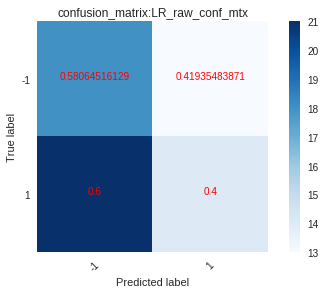

Normalized confusion matrix
[[ 0.4516129   0.5483871 ]
 [ 0.62857143  0.37142857]]


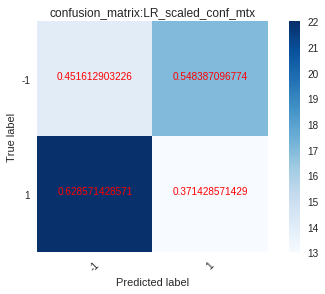

Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


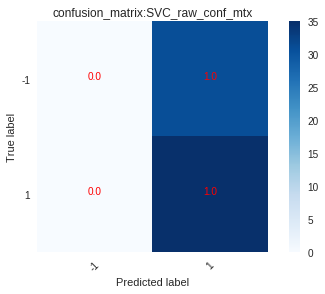

Normalized confusion matrix
[[ 0.41935484  0.58064516]
 [ 0.51428571  0.48571429]]


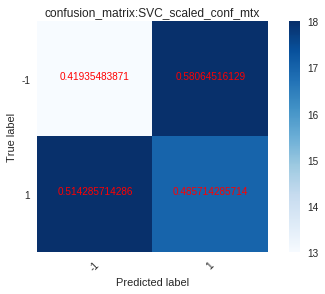

Normalized confusion matrix
[[ 0.29032258  0.70967742]
 [ 0.48571429  0.51428571]]


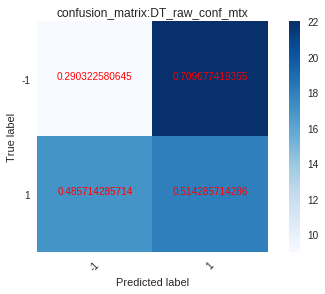

Normalized confusion matrix
[[ 0.29032258  0.70967742]
 [ 0.48571429  0.51428571]]


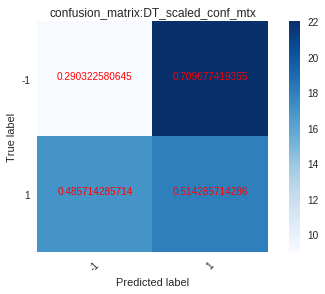

Normalized confusion matrix
[[ 0.61290323  0.38709677]
 [ 0.45714286  0.54285714]]


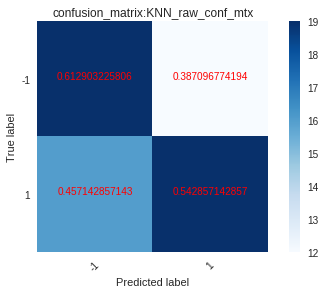

Normalized confusion matrix
[[ 0.29032258  0.70967742]
 [ 0.28571429  0.71428571]]


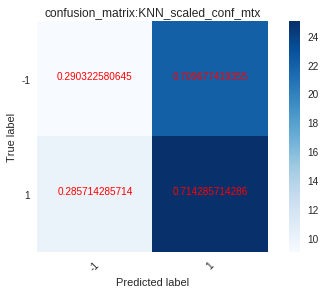

In [34]:
# Plot confusion matrices, for all models.

for k,conf_mtx in confusion_mtx.items():
    plot_confusion_matrix(conf_mtx, classes=['-1','1'], normalize=True,
                          title= 'confusion_matrix:'+k)
    